# Faster R-CNN

- Reference    


원본링크: [Faster R-CNN in Pytorch](https://fractaldle.medium.com/guide-to-build-faster-rcnn-in-pytorch-95b10c273439), [Overall](https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd),[Medium](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439)

리뷰링크: [Faster R-CNN in Pytorch](https://herbwood.tistory.com/11?category=867198)

- [Youtube link](https://www.youtube.com/watch?v=4yOcsWg-7g8&feature=youtu.be)

Faster R-CNN의 전반적인 구조를 아래의 코드를 통해 확인할 수 있습니다. 모듈화가 아닌 순서대로 작성 되었기 때문에 처음 구조를 파악하는데 많은 도움이 될 것이라고 생각됩니다. 코드가 길어지면서 각 변수가 어떤 목적의 객체인지 기억하기 어려워, 각 코드마다 변수에 대한 설명 주석을 기록했습니다. 

- [More Study](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/model/faster_rcnn/faster_rcnn.py) 



## FLOW

1. Region Proposal network(RPN)
2. RPN loss functions
3. Regions of Interest Pooling (ROI)
4. RoI loss functions


## Data flow in Faster R-CNN

1. Features Extraction from the image
2. Creating anchor targets
3. Locations and objectness score prediction from the RPN network
4. Taking the top N locations and their objectness scores a.k.a proposal layer
5. Passing these top N locations through Fast R-CNN network and generating locations and cls predictions for each location is suggested in 4.

6. generating proposal targets for each location suggested in 4
7. Using 2 and 3 to calculate rpn_cls_loss and rpn_reg_loss.
8. using 5 and 6 to calculate roi_cls_loss and roi_reg_loss.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image



- Overall architecture
![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FQhStI%2FbtqQ1Nvi3UG%2F1cZ9NeoiLUXfbK0VblaX80%2Fimg.png)

In [2]:
if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cuda Tesla P100-PCIE-16GB


## Read a batch of training images along with their bounding boxes and labels  

- In this example, I use read only 1 image

(231, 640, 3)


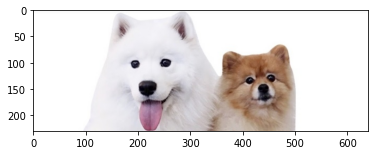

In [9]:
# input image could be of any size
# img0  = cv2.imread("/content/drive/MyDrive/Github/paper-code-review/Faster_R-CNN/Faster_R-CNN/two_dog.jpg")
img0  = cv2.imread("/content/drive/MyDrive/Github/paper-code-review/Faster_R-CNN/Faster_R-CNN/two_dog.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

print(img0.shape)

plt.imshow(img0)
plt.show()

In [10]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels
bbox0 = np.array([[10, 100, 200, 350], [80, 350, 200, 500]])
labels = np.array([1,1]) # 0: background, 1: dog

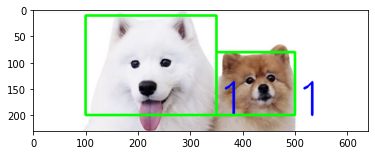

In [11]:
# display bounding box and labels
# cv2.putText
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
  cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3)
  cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)

plt.imshow(img0_clone)
plt.show()

## Resize the input images to (800, 800)

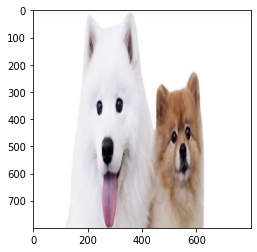

In [12]:
img = cv2.resize(img0, (800, 800), interpolation=cv2.INTER_LINEAR)
plt.imshow(img)
plt.show()

In [13]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
"""

# resize에 상응하는 bounding box로 수정
# change the bouding box coorinates
# 800 x 800
W_ratio = 800/img0.shape[1]
H_ratio = 800/img0.shape[0]

ratioLst= [H_ratio, W_ratio, H_ratio, W_ratio]
bbox = []
for box in bbox0:
  box=[ int(a*b) for a,b in zip(box, ratioLst)]
  bbox.append(box)

bbox = np.array(bbox)
print(bbox)

[[ 34 125 692 437]
 [277 437 692 625]]


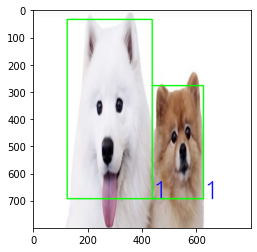

In [14]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3)
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)

plt.imshow(img_clone)
plt.show()

## Use VGG16 to **extract features** from input images

### Input images(batch_size, H=800, W=800, d=3), Features: (batch_size, H=50, W=50, d=512)



In [15]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox

"""

# List all layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))
fe

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

31


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [18]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
"""

# collect layers with output feature mpa size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800]
print(dummy_img.shape)

k = dummy_img.clone().to(device)
print("k.shape: ",k.shape)

n = 0
req_features = []
for layers in fe:
    # print("layers: ", layers)
    k = layers(k)

    if k.size()[2] < 800//16:
      print("break")
      break
    req_features.append(layers)
    out_channels = k.size()[1]
    n +=1
print(len(req_features))
print(out_channels) # VGG output 512x50x50

torch.Size([1, 3, 800, 800])
k.shape:  torch.Size([1, 3, 800, 800])
break
30
512


In [ ]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
"""

# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)
print(faster_rcnn_fe_extractor)

In [19]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
"""
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) # 3x800x800
imgTensor = imgTensor.unsqueeze(0) # 1x3x800x800
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


imgArray[1]: (50, 50)


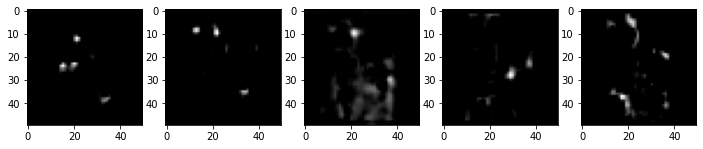

In [20]:

# visualize the first 5 channels of the 50*50*512 feature maps
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo= 1
for i in range(5):
  fig.add_subplot(1, 5, figNo)
  
  plt.imshow(imgArray[i], cmap="gray")
  figNo += 1

print("imgArray[1]:", imgArray[1].shape)

plt.show()

## Generate 22,500 **Anchor boxes** on each input image
- 50x50= 2500 anchors, each anchor generate 9 anchor boxes, Total = 50x50x9 = 22,500

1. Generate Anchor at a feature map location
2. Generate Anchor at all the feature map location
3. Assign the labels and location of objects to each and every anchor
4. Generate Anchor at a feature map location


![](https://miro.medium.com/max/1400/1*-kY2d--m-MauFNEsRw-2zg.png)

In [21]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)

"""
# x, y intervals to generate anchor box centor
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)  
ctr_y = np.arange(16, (fe_size+1) * 16, 16) 

print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [23]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)
"""

# cooridinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
  for y in range(len(ctr_y)):
    ctr[index, 1] = ctr_x[x] - 8
    ctr[index, 0] = ctr_y[y] - 8
    index += 1

print(ctr.shape)
print(ctr)

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 ...
 [760. 792.]
 [776. 792.]
 [792. 792.]]


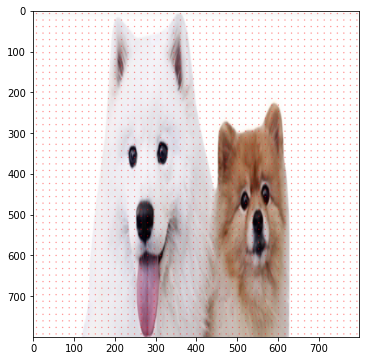

In [24]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
  cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color= (255,0,0), thickness = 1)

plt.imshow(img_clone)
plt.show()

- Anchor boxes size


In [25]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
"""


# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22,500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4)) # 50 * 50 * 9
index = 0

for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(ratios)):
    for j in range(len(scales)):
      h = sub_sample * scales[j] * np.sqrt(ratios[i]) # 16 * ([8, 16, 32]) * sqrt([0.5, 1, 2])
      w = sub_sample * scales[j] * np.sqrt(1./ratios[i]) # 1/root??

      anchor_boxes[index, 0] = ctr_y - h/2 # ymin
      anchor_boxes[index, 1] = ctr_x - w/2 # xmin
      anchor_boxes[index, 2] = ctr_y + h/2 # ymax
      anchor_boxes[index, 3] = ctr_x + w/2 # xmax
      
      index += 1
print(anchor_boxes.shape)

(22500, 4)


In [26]:
anchor_boxes[0]

array([-37.254834  , -82.50966799,  53.254834  ,  98.50966799])

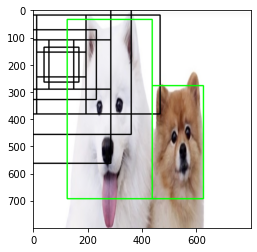

In [27]:
# display the 9 anchor boxes of one anchor and the ground truth box
img_clone = np.copy(img)
for i in range(2808,2817):
  x0 = int(anchor_boxes[i][1])
  y0 = int(anchor_boxes[i][0])
  x1 = int(anchor_boxes[i][3])
  y1 = int(anchor_boxes[i][2])
  cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0,0, 0), thickness=3)

for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3) # Draw Rectangle

plt.imshow(img_clone)
plt.show()

### choose valid anchor box

- Find the indexs of valid anchor boxes and create an array with these indexes. create an label array with shape index array filled with -1
- check weather one of the above conditition a, b, c is statisfying or not and fill the label accordingly. Incase of positive anchor box (label is 1), Note which ground truth object has resulted in this

- calculate the locations (loc) of ground truth associated with the anchor box wrt to the anchor box.

- Reorganize all anchor boxes by filling with -1 for all unvalid anchor boxes and values we have calculated for all valid anchor boxes.

- Outputs should be labels with (N, 1) array and locs with (N, 4) array.

- Find the index of all valid anchor boxes

** [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) : 특정 조건을 만족하는 인덱스 및 지정 값 반환


In [28]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!
valid_anchor_boxes = valid anchors
"""

# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1) > 0 and (y2, x2) <= 800

index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800) 
)[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)
# 8940 only valid boxes

print(valid_anchor_boxes[41])

(8940,)
(8940, 4)
[ 13.49033201  26.745166   194.50966799 117.254834  ]


- IoU   

$$IoU = {Intersection \over A+B - Intersection}$$ 

In [29]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 
ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)

"""

# Calculate IoU of the valid anchor boxes
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with(8940, 2) as the output
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)

    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = max([xb2, xa2])
        inter_y2 = max([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0

        ious[num1, num2] = iou

print(ious.shape)
print(ious[1])

(8940, 2)
[12.530273  4.761963]


In [30]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 
ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)

gt_argmax_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index , (2,)
gt_max_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU 값, (2,)
gt_argmax_ious(override) =  2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index(모든 중복 된 값), (19,)
"""

# What anchor box has max iou with the ground truth bbox
gt_argmax_ious = ious.argmax(axis = 0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious.shape)

[4774 7430]
[ 13.393153 181.18332 ]
(19,)


In [31]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)

anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 

ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)
gt_argmax_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index , (2,)
gt_max_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU 값, (2,)
gt_argmax_ious(override) =  2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index(모든 중복 된 값), (19,)

argmax_ious = 각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 index, (8940,)
max_ious =  각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 값, (8940,)
"""
# What ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious.shape)

(8940,)
[0 0 0 ... 1 1 1]
(8940,)


## IoU with 8940 vaild anchor boxes / 1: object, 0: background, -1:ignore

In [32]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [34]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)

anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 

ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)
gt_argmax_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index , (2,)
gt_max_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU 값, (2,)
gt_argmax_ious(override) =  2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index(모든 중복 된 값), (19,)

argmax_ious = 각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 index, (8940,)
max_ious =  각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 값, (8940,)

label = a,b 조건에 만족하면 1( > 0.7,positive), 만족하지 않으면 0(< 0.3, negative ), 둘 다 해당되지 않으면 -1
"""
# Use IoU to assigm 1 (objects) to two kind of anchors
# a) The anchors with the highest IoU overlap with a GT box
# b) An anchor that has an IoU overlap higher than 0.7 with GTbox

# Assian 0 (background) to an anchor if its IoU ratio is lower than 0.3 for all GT boxes
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

## mini-batch training(=256) with valid anchor boxes in RPN
- 128 positive examples, 128 negative examples

In [35]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)

anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 

ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)
gt_argmax_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index , (2,)
gt_max_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU 값, (2,)
gt_argmax_ious(override) =  2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index(모든 중복 된 값), (19,)

argmax_ious = 각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 index, (8940,)
max_ious =  각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 값, (8940,)

label = a,b 조건에 만족하면 1( > 0.7,positive), 만족하지 않으면 0(< 0.3, negative ), 둘 다 해당되지 않으면 -1
pos_index = label이 1인 index
neg_index = label이 0인 index
label(mini-batch) = positive sample의 수가 128개 이상인 경우, 남는 positive sample에 해당하는 sample은 label 변수에 -1로 지정합니다. negative sample에 대해서도 마찬가지로 수행합니다. 하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출합니다

"""
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
# 만약 positive sample의 수가 128개 이상인 경우, 남는 positive sample에 해당하는 sample은 label 변수에 -1로 지정합니다. negative sample에 대해서도 마찬가지로 수행합니다. 하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출합니다


n_sample = 256
pos_ratio = 0.5
n_pos = int(pos_ratio * n_sample)

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHaclG%2FbtqBdUkizUl%2FOzPRkcX2FPJPFmN8BKlzl1%2Fimg.png)

In [36]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)

anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 

ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)
gt_argmax_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index , (2,)
gt_max_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU 값, (2,)
gt_argmax_ious(override) =  2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index(모든 중복 된 값), (19,)

argmax_ious = 각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 index, (8940,)
max_ious =  각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 값, (8940,)

label = a,b 조건에 만족하면 1( > 0.7,positive), 만족하지 않으면 0(< 0.3, negative ), 둘 다 해당되지 않으면 -1
pos_index = label이 1인 index
neg_index = label이 0인 index
label(mini-batch) = positive sample의 수가 128개 이상인 경우, 남는 positive sample에 해당하는 sample은 label 변수에 -1로 지정합니다. negative sample에 대해서도 마찬가지로 수행합니다. 하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출합니다

max_iou_bbox = argmax_ious의 index 위치 만큼 생성., 8940개 생성
height, width, ctr_y, ctr_x = valid anchor box의 높이, 너비, 센터 포인트
base_height, base_width, base_ctr_y, base_ctr_x = 각각 해당하는 GT bbox의 높이, 너비, 센터포인트
dy, dx, dh, dw = GT bbox와 anchor box의 차이 좌표 값
anchor_locs = np.vstack((dx, dy, dw, dh)).transpose() 
"""

# convert the format of valid anchor boxes [x1, y1, x2, y2]
# For each valid anchor box, find the groundtruth object which has max_iou 

max_iou_bbox = bbox[argmax_ious] # argmax_ious의 index 위치 만큼 생성., 8940개 생성
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] = max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps # float 타입의 한계점
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

# np.vstack은 수직으로 행렬 결합이 이뤄진다.
anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)


(8940, 4)
(8940, 4)


In [37]:
"""
img = img 파일
bbox = 800 x 800으로 수정된 GT bbox
k = dummy_img
faster_rcnn_fe_extractor = 수정된 VGG16 모델
out_map = faster_rcnn_fe_extractor(imgTensor) 실행시킨 결과
ctr_x, ctr_y = anchor box 생성하기 위한 구간 설정(16 pixel)
ctr = anchor box의 center points, shape(2500, 2)

anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
index_inside = Valid한 anchor box들의 index !!!!, (8940,)
valid_anchor_boxes = valid anchors, (8940, 4) 

ious = valid anchor boxes들과 2개의 GT box의 IoU 계산 , (8940, 2)
gt_argmax_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index , (2,)
gt_max_ious = 2개의 GT box와의 IoU 중 각각 가장 큰 IoU 값, (2,)
gt_argmax_ious(override) =  2개의 GT box와의 IoU 중 각각 가장 큰 IoU의 index(모든 중복 된 값), (19,)

argmax_ious = 각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 index, (8940,)
max_ious =  각각의 anchor box들이 2개의 GT bbox 중 더 높은 IoU의 값, (8940,)

label = a,b 조건에 만족하면 1( > 0.7,positive), 만족하지 않으면 0(< 0.3, negative ), 둘 다 해당되지 않으면 -1
pos_index = label이 1인 index
neg_index = label이 0인 index
label(mini-batch) = positive sample의 수가 128개 이상인 경우, 남는 positive sample에 해당하는 sample은 label 변수에 -1로 지정합니다. negative sample에 대해서도 마찬가지로 수행합니다. 하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출합니다

max_iou_bbox = argmax_ious의 index 위치 만큼 생성., 8940개 생성
height, width, ctr_y, ctr_x = valid anchor box의 높이, 너비, 센터 포인트
base_height, base_width, base_ctr_y, base_ctr_x = 각각 해당하는 GT bbox의 높이, 너비, 센터포인트
dy, dx, dh, dw = GT bbox와 anchor box의 차이 좌표 값


anchor_labels = vaild anchor boxes들의 "label"변수 값을 채운다
anchor_locations = gt와 anchor boxes들의 차이
"""

# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes), ) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])


(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## RPN
![](https://miro.medium.com/max/1400/1*rQ99lLIs7xTAjTaKHHNatA.png)

- The network contains a convolution module, on top of which there will be one regression layer, which predicts the location of the box inside the anchor

1) Define RPN

In [38]:

# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device) # 512x36
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)# 512x18
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

2) Classification and Bounding box regression

In [39]:
"""
pred_anchor_locs = bounding box regresor output, bounding box coefficients
pred_cls_scores = classifier output, objectness score
"""

x = conv1(out_map.to(device)) # out_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output, bounding box coefficients
pred_cls_scores = cls_layer(x)  # classifier output, objectness score

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [40]:
"""
pred_anchor_locs = bounding box regresor output, bounding box coefficients
pred_cls_scores = classifier output, objectness score

pred_anchor_locs(override) = [1, 36, 50, 50] -> [1, 22500, 4]
pred_cls_scores(override) =  [1, 18, 50, 50] -> [1, 50, 50, 18]
objectness_score = foreground에 대한 예측만 하는것이다.
pred_cls_scores(override) = [1, 50, 50, 18] -> [1, 22500, 2] ,class 예측을 위해
"""

# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)
# contiguous  PyTorch에서 contiguous는 아마도 tensor에서 바로 옆에 있는 요소가 실제로 메모리상에서 서로 인접해있느냐를 의미한다.
# view의 경우에는 contiguous한 경우에만 실행 가능하다면, permute() transpose()는 언제든지 가능한다.

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[..., 1].contiguous().view(1, -1) 
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [41]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [42]:
"""
pred_anchor_locs = bounding box regresor output, bounding box coefficients
pred_cls_scores = classifier output, objectness score

pred_anchor_locs(override) = [1, 36, 50, 50] -> [1, 22500, 4]
pred_cls_scores(override) =  [1, 18, 50, 50] -> [1, 50, 50, 18]
objectness_score = foreground에 대한 예측만 하는것이다.
pred_cls_scores(override) = [1, 50, 50, 18] -> [1, 22500, 2] ,class 예측을 위해

rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)
"""


rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)


torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


3) Multi-task loss

$$L(\left\{  p_i  \right\}, \left\{ t_i \right\}) = \frac {1} {N_{cls}} \sum_i L_{cls}(p_i, p_i^*) + \lambda \frac {1} {N_{reg}} \sum_i p_i^* L_{reg}(t_i, t_i^*)
$$   



- L_cls :cross-entropy loss
- L_reg : [Smooth L1 loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html)

In [43]:

#For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward0>)


In [44]:
"""
pred_anchor_locs = bounding box regresor output, bounding box coefficients
pred_cls_scores = classifier output, objectness score

pred_anchor_locs(override) = [1, 36, 50, 50] -> [1, 22500, 4]
pred_cls_scores(override) =  [1, 18, 50, 50] -> [1, 50, 50, 18]
objectness_score = foreground에 대한 예측만 하는것이다.
pred_cls_scores(override) = [1, 50, 50, 18] -> [1, 22500, 2] ,class 예측을 위해

rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

anchor_labels = vaild anchor boxes들의 "label"변수 값을 채운다
anchor_locations = vaild anchor boxes들의 좌표값을 채운다.
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

rpn_cls_loss = cls의 Cross_entropy loss
rpn_loc_loss = smooth L1 loss
"""

# only positive samples
pos = gt_rpn_score > 0 
#.expand_as(tensor), tensor의 shape으로 expand한다.
mask = pos.unsqueeze(1).expand_as(rpn_loc) # regression loss는 오직 positive에 해당하는 sample에 대해서만 loss를 계산하므로, positive/negative 여부를 저장하는 배열인 mask를 생성해줍니다
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4) # True만 반환
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5)) # smooth L1 loss
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([128, 4]) torch.Size([128, 4])
tensor(274.9999, dtype=torch.float64, grad_fn=<SumBackward0>)


In [45]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(22.1791, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


## Proposal layer


1) Transform anchor boxes

- 먼저 score 변수에 저장된 objectness score를 내림차순으로 정렬한 후 objectness score 상위 N(n_train_pre_nms=12000)개의 anchor box에 대하여 Non maximum suppression 알고리즘을 수행합니다. 남은 anchor box 중 상위 N(n_train_post_nms=2000)개의 region proposals를 학습에 사용합니다

In [46]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh = 0.7 # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no, of train pre_NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [47]:
"""
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
anc_height, anc_width, anc_ctr_y, anc_ctr_x = anchor box의 높이, 너비, 센터 포인트

"""

# the labeled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [48]:
"""
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
anc_height, anc_width, anc_ctr_y, anc_ctr_x = anchor box의 높이, 너비, 센터 포인트

pred_anchor_locs = bounding box regresor output, bounding box coefficients, [1, 22500, 4]
objectness_score = foreground에 대한 예측만 하는것이다, [1, 22500]
pred_anchor_locs_numpy = numpy, [22500, 4]
objectness_score_numpy = numpy, [22500]

dy, dx, dh, dw = predicted by RPN coordinate
"""

# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [49]:
"""
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
anc_height, anc_width, anc_ctr_y, anc_ctr_x = anchor box의 높이, 너비, 센터 포인트

pred_anchor_locs = bounding box regresor output, bounding box coefficients, [1, 22500, 4]
objectness_score = foreground에 대한 예측만 하는것이다, [1, 22500]
pred_anchor_locs_numpy = numpy, [22500, 4]
objectness_score_numpy = numpy, [22500]

dy, dx, dh, dw = predicted by RPN coordinate

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
"""

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [50]:
"""
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
anc_height, anc_width, anc_ctr_y, anc_ctr_x = anchor box의 높이, 너비, 센터 포인트

pred_anchor_locs = bounding box regresor output, bounding box coefficients, [1, 22500, 4]
objectness_score = foreground에 대한 예측만 하는것이다, [1, 22500]
pred_anchor_locs_numpy = numpy, [22500, 4]
objectness_score_numpy = numpy, [22500]

dy, dx, dh, dw = predicted by RPN coordinate

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

roi = 예측된 좌표들
"""
# pred_anchor_locs_numpy.shape = (22500, 4)
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


2) Clip the anchor boxes to the image

numpy.clip(array, min, max)

- array 내의 element들에 대해서
- min 값 보다 작은 값들을 min값으로 바꿔주고
- max 값 보다 큰 값들을 max값으로 바꿔주는 함수.

In [51]:
# clip the predicted boxes to the image
img_size = (800, 800)

# 만약의 범위 설정...
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]  slice(0, 4, 2) = [0:4:2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))


(22500, 4) 800.0 0.0


In [53]:
"""
anchor_boxes = 50x50x9 anchors (ymin, xmin, ymax, xmax)
anc_height, anc_width, anc_ctr_y, anc_ctr_x = anchor box의 높이, 너비, 센터 포인트

pred_anchor_locs = bounding box regresor output, bounding box coefficients, [1, 22500, 4]
objectness_score = foreground에 대한 예측만 하는것이다, [1, 22500]
pred_anchor_locs_numpy = numpy, [22500, 4]
objectness_score_numpy = numpy, [22500]

dy, dx, dh, dw = predicted by RPN coordinate

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

roi = 예측된 좌표들
min_size = 16
keep = y,x의 범위가  min_size보다 큰 index
roi(override) = keep 범위에 포함되는 기존의 roi
score = keep 범위에 포함되는 objectness_score_numpy

"""
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1] # y범위
ws = roi[:, 2] - roi[:, 0] # x범위

keep = np.where((hs >= min_size) & (ws >= min_size))[0] # ???
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


3) Selcet top-12000 anchor boxes by objectness score

In [54]:
"""
roi = 예측된 좌표들
min_size = 16
keep = y,x의 범위가  min_size보다 큰 index
roi(override) = keep 범위에 포함되는 기존의 roi
score = keep 범위에 포함되는 objectness_score_numpy
order = score값을 내림차순으로!!!!!
"""
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [55]:
"""
roi = 예측된 좌표들
min_size = 16
keep = y,x의 범위가  min_size보다 큰 index
roi(override) = keep 범위에 포함되는 기존의 roi
score = keep 범위에 포함되는 objectness_score_numpy
order = score값을 내림차순으로!!!!!
n_train_pre_nms = 12000


order(override) = score 값이 큰 순서대로 12000
roi(override) = score 값이 큰 순서대로 12000들의 roi
"""

# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


In [56]:
roi.shape

(12000, 4)

4) Non maximum suppression(select 2000 bounding boxes)


In [57]:
"""
roi = 예측된 좌표들
min_size = 16
keep = y,x의 범위가  min_size보다 큰 index
roi(override) = keep 범위에 포함되는 기존의 roi
score = keep 범위에 포함되는 objectness_score_numpy
order = score값을 내림차순으로!!!!!
n_train_pre_nms = 12000


order(override) = score 값이 큰 순서대로 12000
roi(override) = score 값이 큰 순서대로 12000들의 roi

areas = boxes의 범위
"""

# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [58]:
"""
roi = 예측된 좌표들
min_size = 16
keep = y,x의 범위가  min_size보다 큰 index
roi(override) = keep 범위에 포함되는 기존의 roi
score = keep 범위에 포함되는 objectness_score_numpy
order = score값을 내림차순으로!!!!!
n_train_pre_nms = 12000

order(override) = score 값이 큰 순서대로 12000
roi(override) = score 값이 큰 순서대로 12000들의 roi

areas = boxes의 범위
"""

# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
    i = order[0]  # take the 1st elt in roder and append to keep
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms]
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


## Proposal Target layer


1) Calculate IoUs

In [ ]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
"""
roi = 예측된 좌표들
min_size = 16
keep = y,x의 범위가  min_size보다 큰 index
roi(override) = keep 범위에 포함되는 기존의 roi
score = keep 범위에 포함되는 objectness_score_numpy
order = score값을 내림차순으로!!!!!
n_train_pre_nms = 12000

order(override) = score 값이 큰 순서대로 12000
roi(override) = score 값이 큰 순서대로 12000들의 roi

areas = boxes의 범위
"""

# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype= np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 2)


In [ ]:
"""
gt_assignment = 2개의 GT box중 더 큰 index 
gt_roi_label = 각 index에 해당하는 label 즉, 각 predicted된 anchor box와 상응하는 GT
"""
# find out which GT has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis = 1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[1 0 0 ... 0 0 0]
[0.02629031 0.         0.         ... 0.02949916 0.04439963 0.0999637 ]
[1 1 1 ... 1 1 1]


2) Select foreground samples

In [ ]:
"""
gt_assignment = 2개의 GT box중 더 큰 index 
gt_roi_label = 각 index에 해당하는 label 즉, 각 predicted된 anchor box와 상응하는 GT

pos_roi_per_this_image = Positive한 foreground samples

"""
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

23
[ 800  691  742  919 1529  685 1370 1359  799  805  687  866 1462  918
 1858 1610  751  857 1553 1598 1703 1421  749]


3) Select background samples

In [ ]:
"""
gt_assignment = 2개의 GT box중 더 큰 index 
gt_roi_label = 각 index에 해당하는 label 즉, 각 predicted된 anchor box와 상응하는 GT

pos_roi_per_this_image = Positive한 foreground samples
neg_roi_per_this_image = Negative한 foreground samples
"""

# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

105
[1873 1431 1847 1455  348  896 1082 1019 1958  210  318 1494  648    1
  192  500 1128  405 1152 1211 1608  255  626 1033 1016 1192 1505 1617
  621  841  317  362 1400  502 1403 1879 1782  116  973  970  250 1176
  446   89  166  525  402 1469 1195 1638   35 1160 1439 1863  468  992
  990 1700  719  934 1217 1460 1209  118 1423   70 1254 1861  705 1491
  607   83 1181  369 1542  736 1877  735  217 1713 1612 1860  558  681
  193   26 1481 1747 1241   74  438 1069 1168 1119  539 1519  830  415
 1497  411  204 1325  814 1381 1712]


4) Visualization

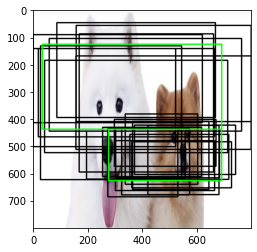

In [ ]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(0,0,0),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

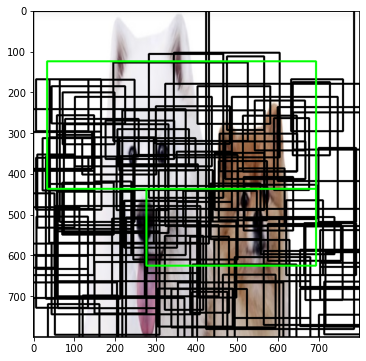

In [ ]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(0, 0, 0),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

5) Gather positive/negative samples


In [ ]:
"""

pos_index = label이 1인 index
neg_index = label이 0인 index

gt_assignment = 2개의 GT box중 더 큰 index 
gt_roi_label = 각 index에 해당하는 label 즉, 각 predicted된 anchor box와 상응하는 GT

pos_roi_per_this_image = Positive한 foreground samples
neg_roi_per_this_image = Negative한 foreground samples
"""

# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [ ]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [ ]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [ ]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## ROI pooling



1) Concatenate labels with bbox coordinates

In [ ]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [ ]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


2) RoI Pooling

In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])


In [ ]:
# adaptive_max_pool
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i].long()
  im_idx = roi[0]
  im = out_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


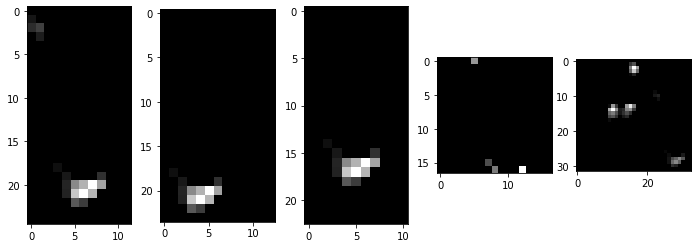

In [ ]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i].long()
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [ ]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


# Fast R-CNN 

1) Classifier and Bounding box regressor

In [ ]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device) # 1 class, 1 background

In [ ]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [ ]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2) Classification loss


In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


3) Regression loss

In [ ]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [ ]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [ ]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [ ]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([23, 4]) torch.Size([23, 4])
tensor(2.1855, dtype=torch.float64, grad_fn=<SumBackward0>)


4) Multi-task loss

In [ ]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss.sum())

total_loss = rpn_loss.cpu() + roi_loss
print(total_loss.sum())

tensor(84.3527, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2163.8740, dtype=torch.float64, grad_fn=<SumBackward0>)
